In [1]:
import json
import requests
import pathlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import pandas as pd
import numpy as np
import cartopy
from erddapy import ERDDAP
plt.rcParams.update({'font.size': 14})

### 1. Download glider datasets from our own ERDDAP

In [2]:
# Setup initial ERDDAP connection
e = ERDDAP(
  server="https://erddap.observations.voiceoftheocean.org/erddap",
  protocol="tabledap",
)

# Fetch dataset list

e.response = "csv"
e.dataset_id = "allDatasets"
df_datasets = e.to_pandas()

datasets = df_datasets.datasetID
# Select only nrt datasets
nrt_datasets = datasets[datasets.str[:3] == "nrt"].values


In [3]:
# Specify variables of interest
e.variables = [
    "latitude",
    "longitude",
    "salinity",
    "temperature",
    "time",
    "pressure",
    "oxygen_concentration",
    "chlorophyll",
]

# Download each dataset and save as xarray
glider_datasets = {}
for ds_name in nrt_datasets:
    e.dataset_id = ds_name
    ds = e.to_xarray()
    glider_datasets[ds_name] = ds

In [4]:
ds

<xarray.Dataset>
Dimensions:               (timeseries: 324, obs: 15742)
Coordinates:
    depth                 (obs) float64 ...
    latitude              (obs) float64 ...
    longitude             (obs) float64 ...
    time                  (obs) datetime64[ns] ...
Dimensions without coordinates: timeseries, obs
Data variables:
    profile_index         (timeseries) float64 ...
    rowSize               (timeseries) int32 ...
    salinity              (obs) float64 ...
    temperature           (obs) float64 ...
    pressure              (obs) float64 ...
    oxygen_concentration  (obs) float64 ...
    chlorophyll           (obs) float64 ...
Attributes: (12/73)
    acknowledgement:               This study used data collected and made fr...
    altimeter:                     {'make': 'UNKNOWN', 'model': 'UNKNOWN', 's...
    basin:                         Skagerrak, Kattegat
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      profile_index
    comment:                       deployment and recovery in Kattegat/Skagerrak
    ...                            ...
    time_coverage_end:             2022-09-07T00:18:26Z
    time_coverage_start:           2022-08-15T08:05:08Z
    title:                         Vass61-20220815T0805
    transmission_system:           IRIDIUM
    Westernmost_Easting:           10.84965
    wmo_id:                        6801706

### 2. Get nearest SMHI station data

Download SMHI data from [sharkweb](https://sharkweb.smhi.se/hamta-data/). This uses some urls constructed from [defunct SMHI Python 2.7 code](https://sharkdata.smhi.se/examplecode/) as a starting point 

In [5]:
base_url = 'https://sharkdata.smhi.se/datasets/'
dataset_list_url = base_url + 'list.json'
datasets = json.loads(requests.get(dataset_list_url).text)
print(f"found {len(datasets)} datasets")
physical_datasets = []
for ds in datasets:
    if ds['datatype'] == 'PhysicalChemical':
        physical_datasets.append(ds)
print(f"Of these datasets, {len(physical_datasets)} are physical")

found 3303 datasets
Of these datasets, 1823 are physical


In [6]:
smhi_dir = pathlib.Path('smhi_data_cache')
if not smhi_dir.exists():
    print(f"creating directory to cache SMHI datasets at {smhi_dir.absolute()}")
    smhi_dir.mkdir(parents=True, exist_ok=True)

#### Download the datasets

Here we are working only with physical/chemical datasets. To download all of the datasets, replace `physical_datasets` with `datasets` in the first line of the cell below

In [7]:
for ds_dict in tqdm(physical_datasets):
    ds_name = ds_dict["dataset_name"]
    ds_name_and_date = ds_dict["dataset_file_name"]
    ds_file = smhi_dir / (ds_name_and_date[:-3] + "csv")
    if ds_file.exists():
        # If file exists, don't re-download it
        continue
    same_name_files = list(smhi_dir.glob(f"{ds_name}*"))
    if same_name_files:
        # File exists with the same name but different date. Replace with (presumably newer) file from server
        old_file = same_name_files[0]
        old_file.unlink()
        print(f"Deleting {old_file}")
    print(f"Download {ds_file}")
    download_url = base_url + ds_name + '/data.txt'
    df = pd.read_csv(download_url, encoding='cp1252', sep='\t')
    df.to_csv(ds_file, index=False)

  0%|          | 0/1823 [00:00<?, ?it/s]

#### Read SMHI csv files into one big DataFrame

**NB** this is a big datasets, so we're only reading a subset of columns to keep memory under control

In [8]:
files = smhi_dir.glob("*.csv")
desired_cols = [
 'station_name',
 'sample_location_id',
 'station_id',
 'visit_id',
 'shark_sample_id',
 'visit_date',
 'sample_latitude_dd',
 'sample_longitude_dd',
 'water_depth_m',
 'sample_id',
 'sample_depth_m',
 'sample_comment',
 'parameter',
 'value',
 'unit',
 'quality_flag',
 'dataset_name']
df = pd.concat((pd.read_csv(f,low_memory=False, parse_dates=['visit_date'], usecols=desired_cols) for f in files))
print(f"DataFrame uses {int(df.memory_usage().sum() / 1e6)} mB of memory")

DataFrame uses 1036 mB of memory


#### Subset the DataFrame

We're only interested in temperature, salinity and chlorophyll data, but there are a lot of variables in this DataFrame. Let's subset it. **NB** this list of desired terms could be expanded to other variables

In [9]:
np.unique(df.parameter)

array(['Alkalinity', 'Alkalinity_2', 'Aluminium', 'Ammonium NH4-N',
       'Chlorophyll-a bottle', 'Coloured dissolved organic matter CDOM',
       'Conductivity CTD', 'Conductivity_25 bottle', 'Current direction',
       'Current velocity', 'Dissolved organic carbon DOC',
       'Dissolved oxygen O2 CTD', 'Dissolved oxygen O2 bottle', 'Humus',
       'Hydrogen sulphide H2S', 'Lignin', 'Nitrate NO3-N',
       'Nitrite NO2-N', 'Nitrite+Nitrate NO2+NO3-N',
       'Particulate organic carbon POC',
       'Particulate organic nitrogen PON', 'Phosphate PO4-P',
       'Pressure CTD', 'Salinity CTD', 'Salinity bottle', 'Secchi depth',
       'Silicate SiO3-Si', 'Temperature CTD', 'Temperature bottle',
       'Temperature pH Laboratory', 'Total Nitrogen Tot-N',
       'Total organic carbon TOC', 'Total phosphorus Tot-P', 'Urea',
       'Yellow substance', 'pH', 'pH Laboratory'], dtype=object)

In [10]:
desired_variables = ['Chlorophyll-a bottle', 'Conductivity CTD', 'Dissolved oxygen O2 CTD', 
                    'Pressure CTD', 'Salinity CTD', 'Temperature CTD']
search_regex = "|".join(desired_variables)
matching_rows = df.parameter.str.contains(search_regex)
df = df[matching_rows].reset_index(drop=True)
print(f"DataFrame uses {int(df.memory_usage().sum() / 1e6)} mB of memory")

DataFrame uses 155 mB of memory


In [11]:
np.unique(df.parameter)

array(['Chlorophyll-a bottle', 'Conductivity CTD',
       'Dissolved oxygen O2 CTD', 'Pressure CTD', 'Salinity CTD',
       'Temperature CTD'], dtype=object)

#### Further subsetting
For our glider observatory, we are only interested in SMHI data from 2020-06 onward and in water deeper than 50 m. Further constraints could be added

In [12]:
df = df[df.visit_date > datetime.datetime(2020,6,1)]
print(f"DataFrame uses {int(df.memory_usage().sum() / 1e6)} mB of memory")
df = df[df.water_depth_m > 50]
print(f"DataFrame uses {int(df.memory_usage().sum() / 1e6)} mB of memory")

DataFrame uses 13 mB of memory
DataFrame uses 7 mB of memory


In [13]:
stations_df = df.groupby('station_id').first()

### Create map

A scatter plot of SMHI monitoring stations

Text(0.5, 1.0, 'SMHI monitoring stations')

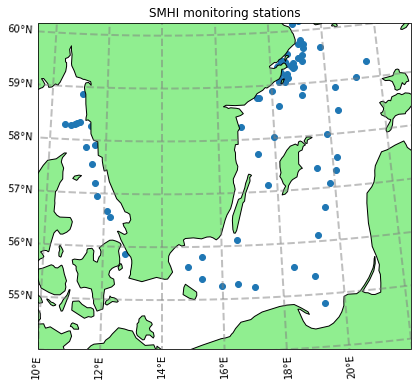

In [14]:
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=14, central_latitude=56)
pc = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=coord)
ax.set_extent([10, 22, 54, 60], crs=pc)

feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
                                              scale='50m', edgecolor='black', facecolor='lightgreen')
ax.add_feature(feature)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = None
gl.right_labels = None

ax.scatter(stations_df['sample_longitude_dd'], stations_df['sample_latitude_dd'], transform=pc)
plt.title("SMHI monitoring stations")

kludge an identifier to uniquiely id each station visit

In [15]:
df["station_visit"] = df['station_id'] * 100000 + df['visit_id']

In [16]:
len(np.unique(df.sample_location_id))

105

In [17]:
station_visit_df =  df.groupby('station_visit').first()

### 3. Find nearest SMHI profile to glider missions

In [18]:
def format_difference(deg_e, deg_n, ns_ahead):
    """
    Pretty formatting for a lon, lat, time difference between two points
    """
    km_n = (111 * deg_n).round(1)
    km_e = (111 * deg_e * np.cos(np.deg2rad(deg_n))).round(1)
    h_ahead = (np.float64(ns_ahead) / (1e9 * 60 * 60)).round(1)
    if km_n > 0:
        north_str = f"{km_n} km N"
    else:
        north_str = f"{-km_n} km S"
    if km_e > 0:
        east_str = f"{km_e} km E"
    else:
        east_str = f"{-km_e} km W"
    if h_ahead > 0:
        time_str = f"{h_ahead} hours later"
    else:
        time_str = f"{-h_ahead} hours earlier"
    return east_str, north_str, time_str

In [19]:
def smhi_profiles_in_range(lon, lat, time, lon_window, lat_window, time_window, df = station_visit_df, min_depth=80):
    """
    Returns the station IDs of stations within a certain range of a point in space and time
    """
    min_lon = lon - lon_window
    max_lon = lon + lon_window
    min_lat = lat - lat_window
    max_lat = lat + lat_window
    min_time = time - time_window
    max_time = time + time_window
    lon_filter = np.logical_and(df['sample_longitude_dd'] > min_lon, df['sample_longitude_dd'] < max_lon)
    lat_filter = np.logical_and(df['sample_latitude_dd'] > min_lat, df['sample_latitude_dd'] < max_lat)
    time_filter = np.logical_and(df['visit_date'] > min_time, df['visit_date'] < max_time)
    df_in_range = df[lon_filter & lat_filter & time_filter]
    # Filter out shallow stations
    df_in_range = df_in_range[df_in_range['water_depth_m'] > min_depth]
    if df_in_range.empty:
        return None
    
    closest_arg = np.argmin(np.abs(df_in_range['visit_date'] - time))
    closest_datasetid = df_in_range.index[closest_arg]
    return closest_datasetid


In [20]:
def nearest_smhi_station(ds_glider, lat_window=0.5, lon_window=1, time_window = np.timedelta64(10, "D")):
    """
    Finds the nearest SMHI station profile to a supplied glidermission. Uses sharkweb data file
    """
    mean_lon = ds_glider.longitude.mean().values
    mean_lat = ds_glider.latitude.mean().values
    mean_time = ds_glider.time.mean().values
    min_time = str(mean_time-time_window)[:10]
    max_time = str(mean_time+time_window)[:10]
    nearest_profile = smhi_profiles_in_range(mean_lon, mean_lat, mean_time, lat_window, lon_window, time_window)
    if nearest_profile:
        closest_station = station_visit_df[station_visit_df.index == nearest_profile]
        deg_e = mean_lon - closest_station['sample_longitude_dd'].values[0]
        deg_n = mean_lat - closest_station['sample_latitude_dd'].values[0]
        time_diff = mean_time - closest_station['visit_date'].values[0]
        east_diff, north_diff, time_diff = format_difference(deg_e, deg_n, time_diff)
        loc_str = f"Nearest station profile is {east_diff}, {north_diff} & {time_diff} than mean of glider data"
        print(loc_str)
        df_nearest = df[df.station_visit == nearest_profile]
        return df_nearest
    else:
        print("No SMHI profiles found within tolerances")
        return None

smhi_datasets = {}
for name, ds in glider_datasets.items():
    print(f"Trying dataset {name}")
    smhi_datasets[name] = nearest_smhi_station(ds, lat_window=1, lon_window=2)
fail, success = 0, 0
for val in smhi_datasets.values():
    if val is not None:
        success+=1
    else:
        fail+=1
print(f"\nsuccess: {success}, fail: {fail}")  

Trying dataset nrt_SEA068_M27
No SMHI profiles found within tolerances
Trying dataset nrt_SEA069_M9
No SMHI profiles found within tolerances
Trying dataset nrt_SEA055_M24
Nearest station profile is 21.0 km E, 19.1 km N & 110.6 hours later than mean of glider data
Trying dataset nrt_SEA055_M31
Nearest station profile is 97.7 km E, 7.4 km N & 61.5 hours later than mean of glider data
Trying dataset nrt_SEA055_M33
No SMHI profiles found within tolerances
Trying dataset nrt_SEA055_M35
No SMHI profiles found within tolerances
Trying dataset nrt_SEA055_M37
Nearest station profile is 23.7 km E, 20.4 km N & 219.0 hours earlier than mean of glider data
Trying dataset nrt_SEA055_M39
No SMHI profiles found within tolerances
Trying dataset nrt_SEA055_M41
Nearest station profile is 6.3 km E, 40.8 km S & 43.1 hours earlier than mean of glider data
Trying dataset nrt_SEA055_M43
Nearest station profile is 25.2 km E, 20.4 km N & 168.3 hours earlier than mean of glider data
Trying dataset nrt_SEA055_M45

/tmp/ipykernel_17012/1570458999.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2,2, sharey="row", figsize=(12, 12))


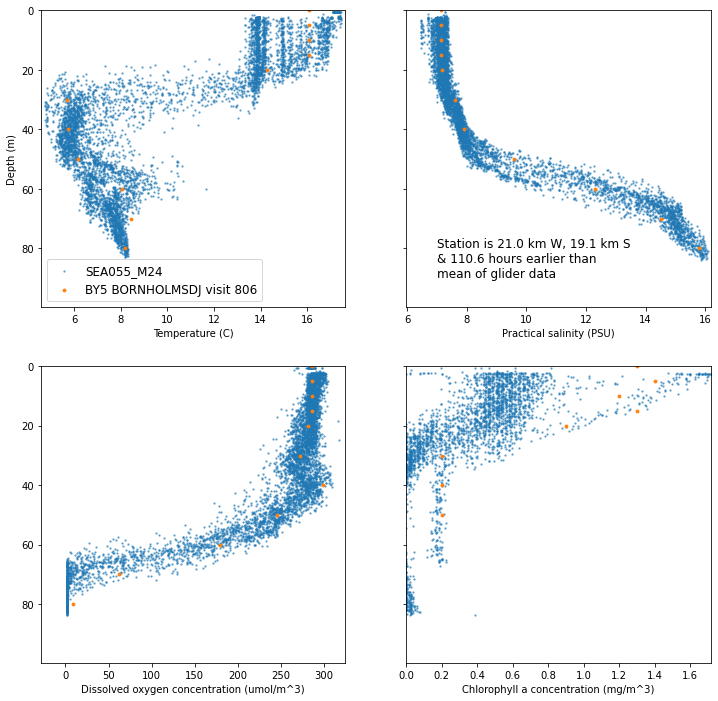

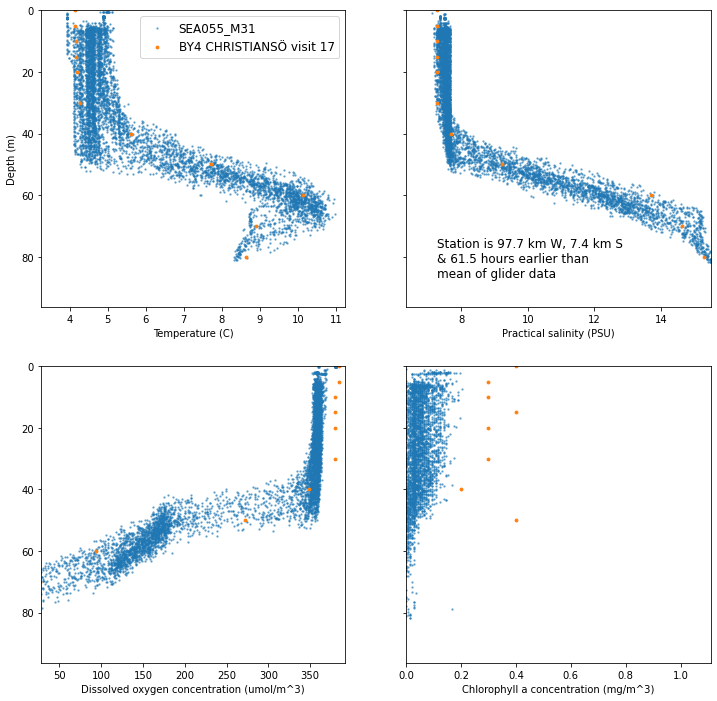

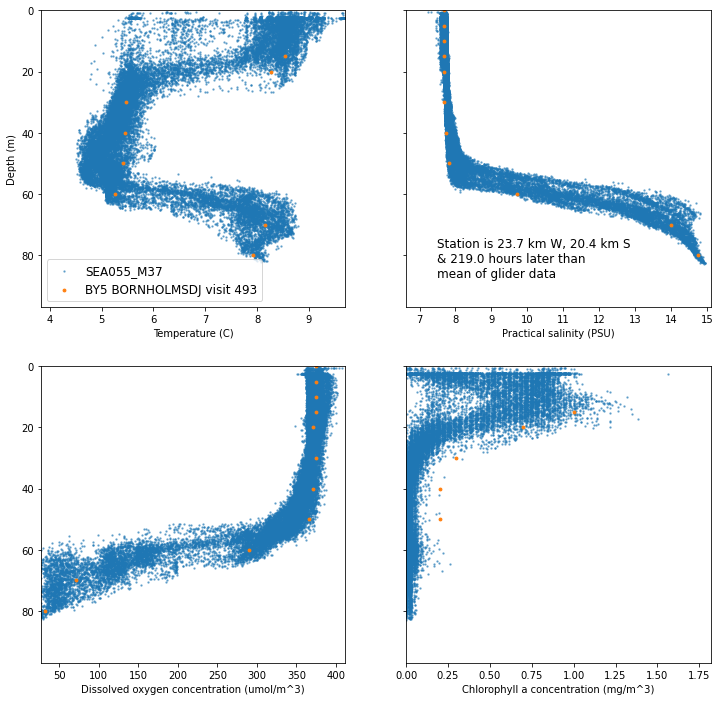

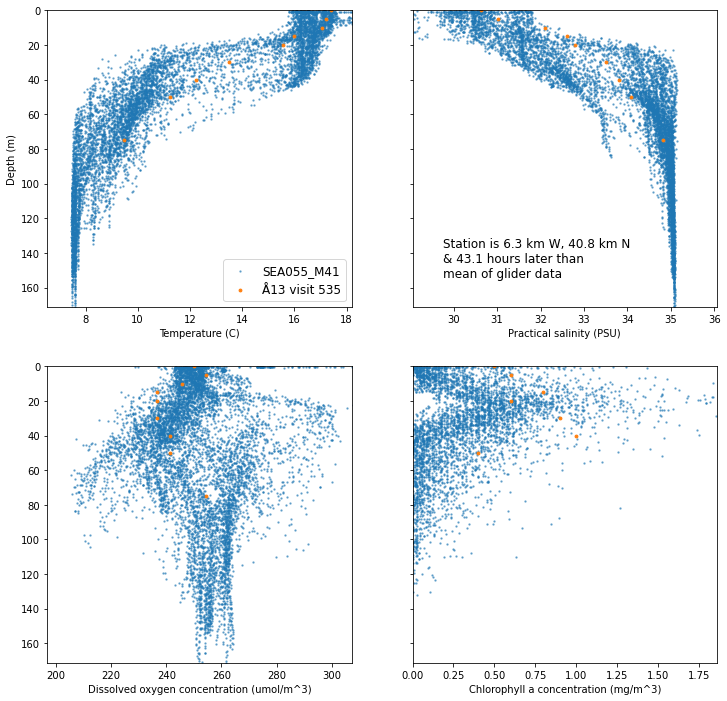

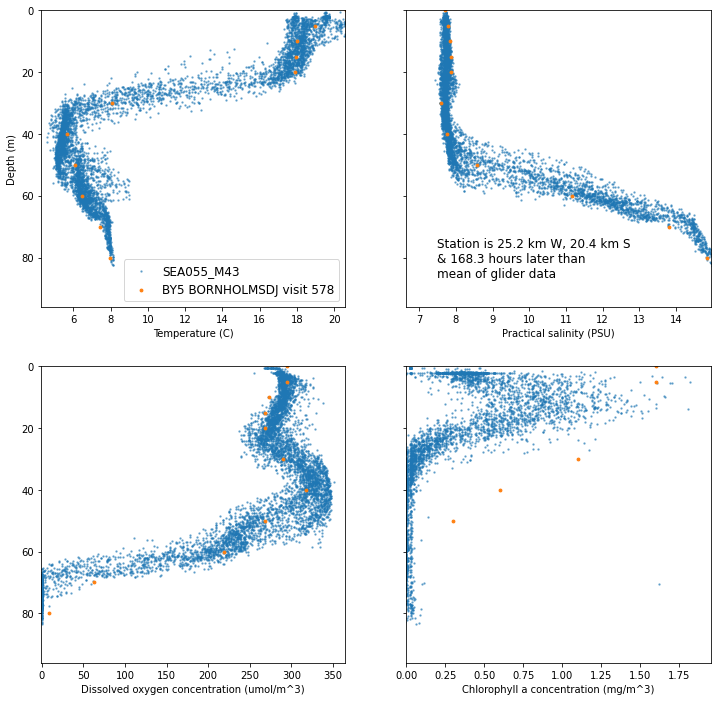

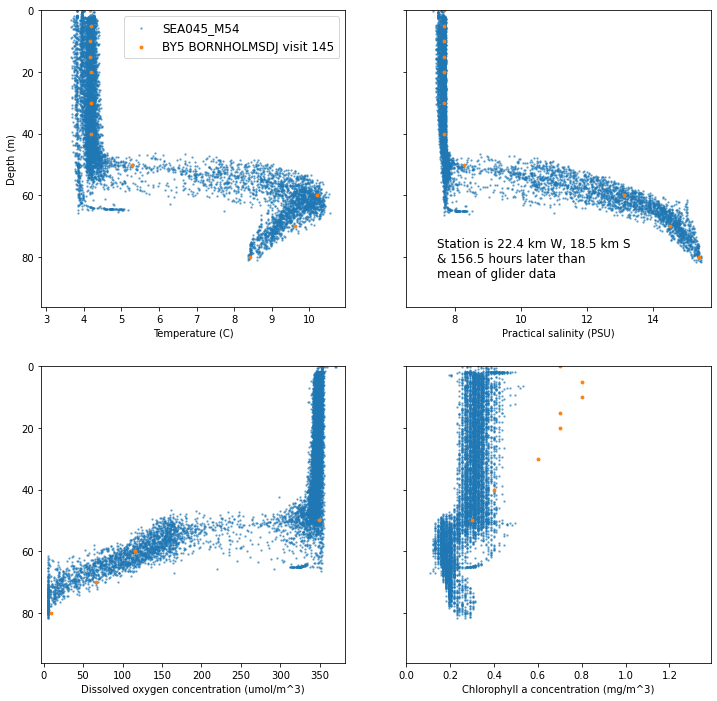

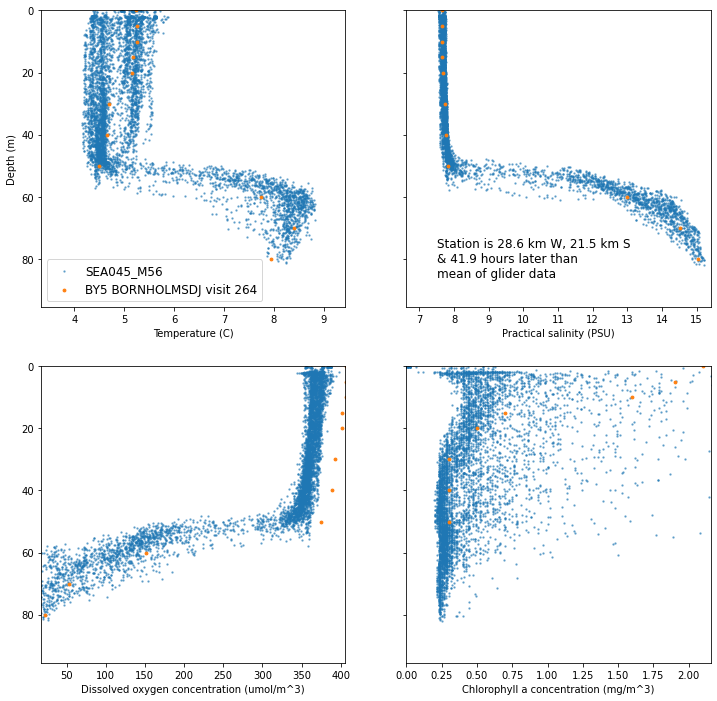

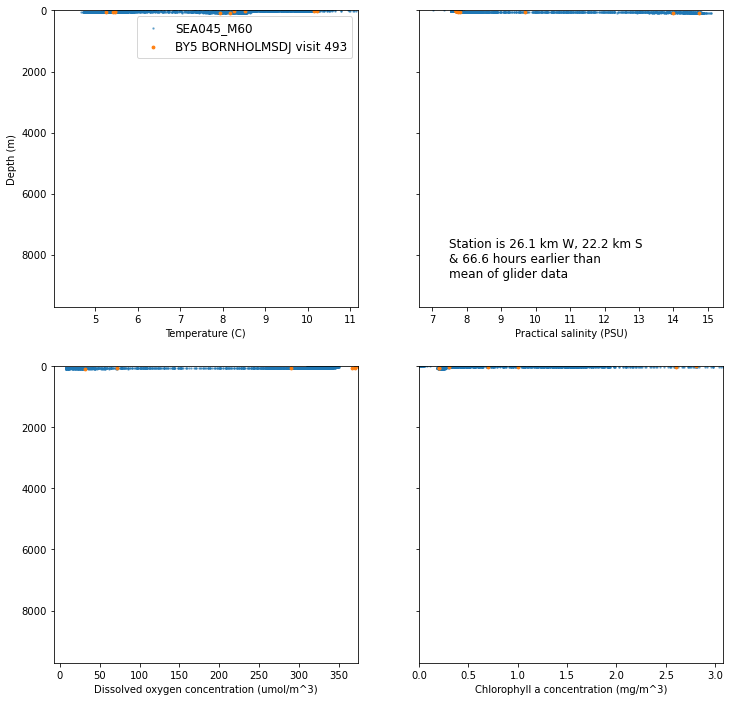

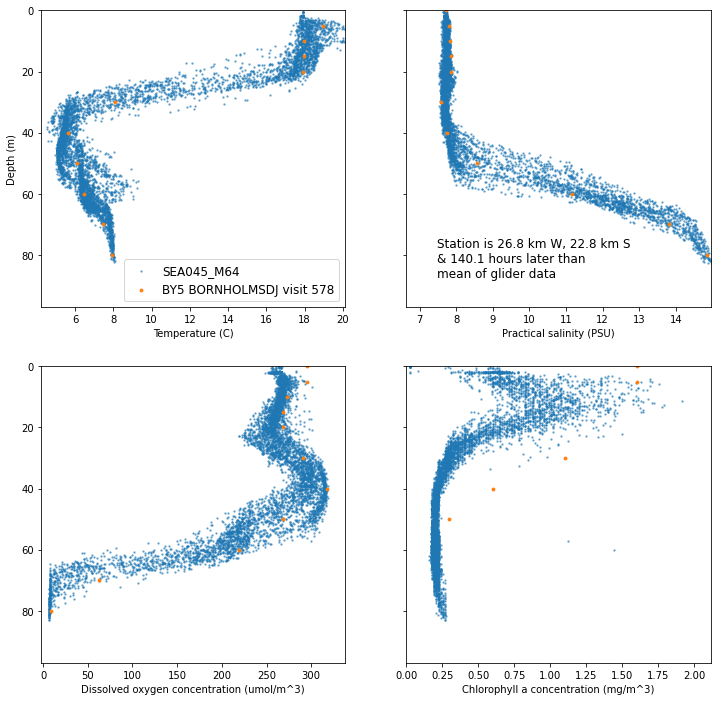

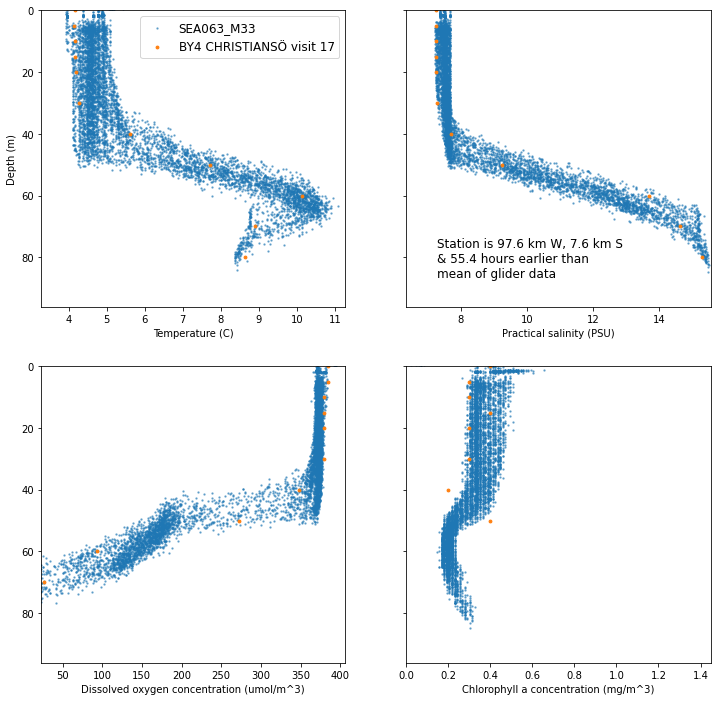

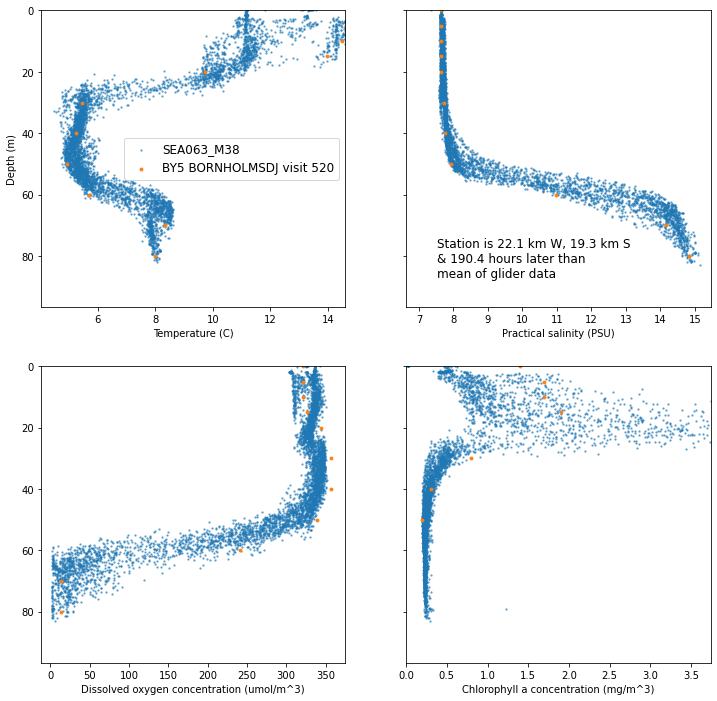

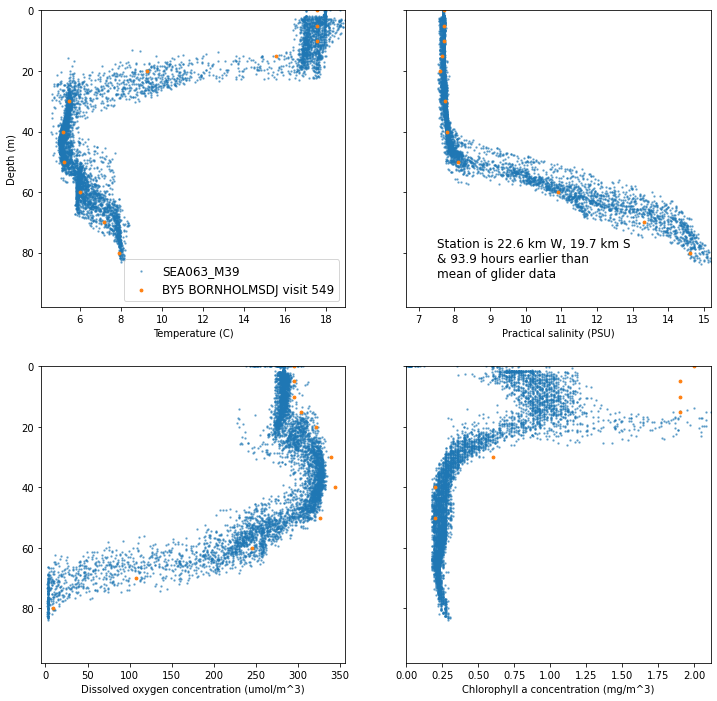

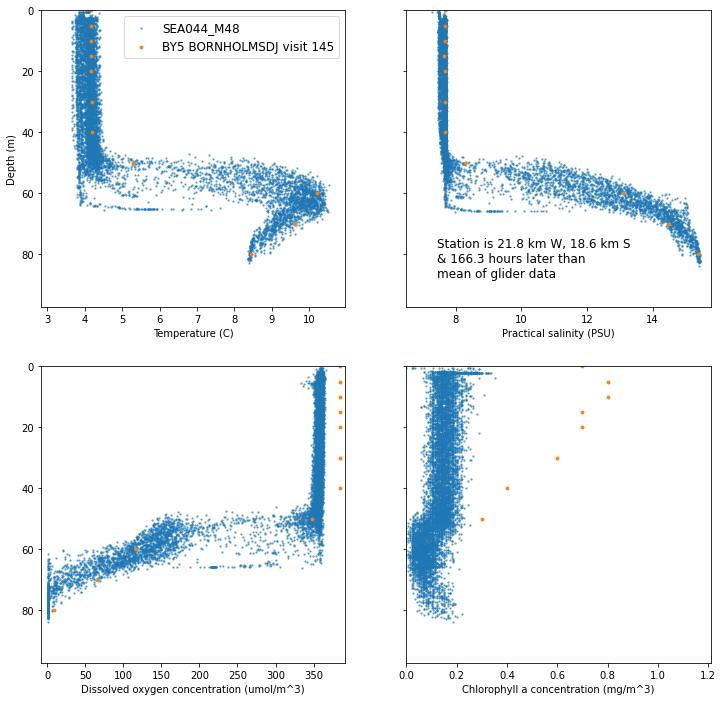

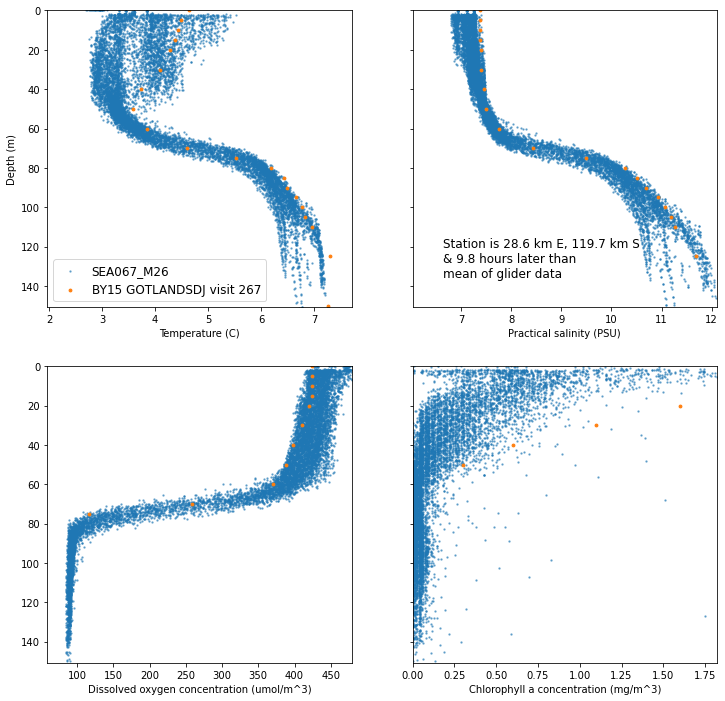

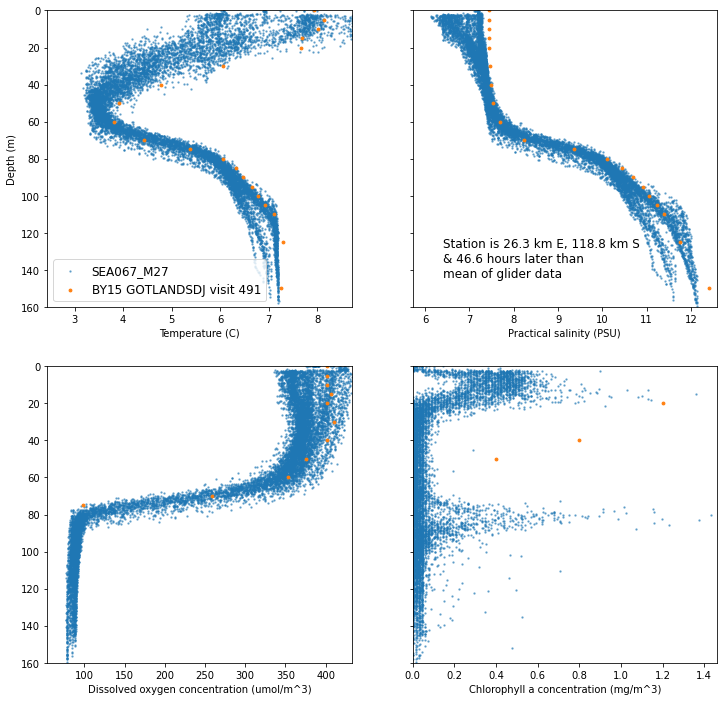

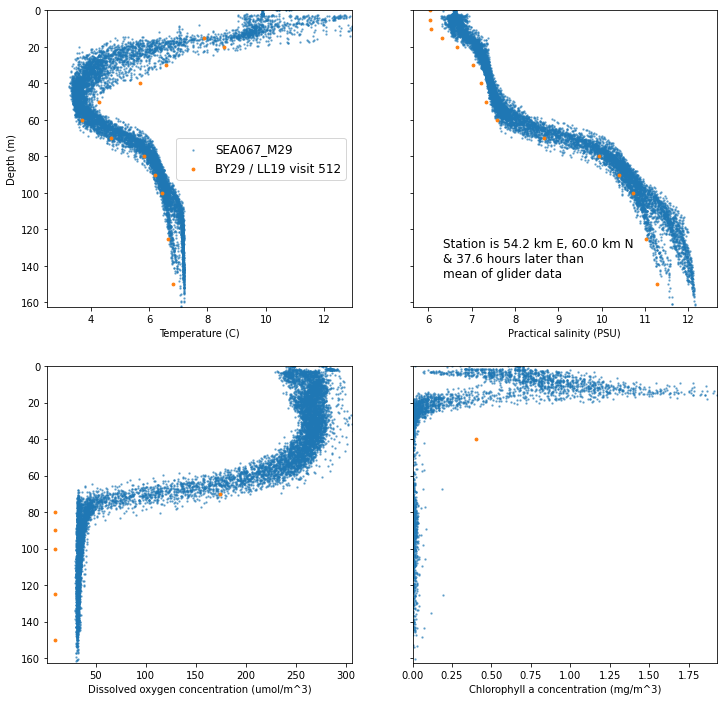

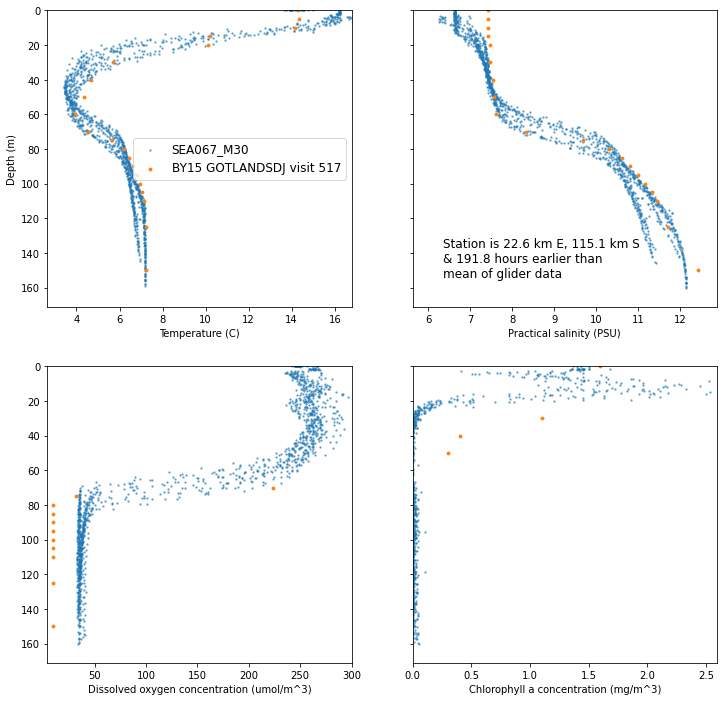

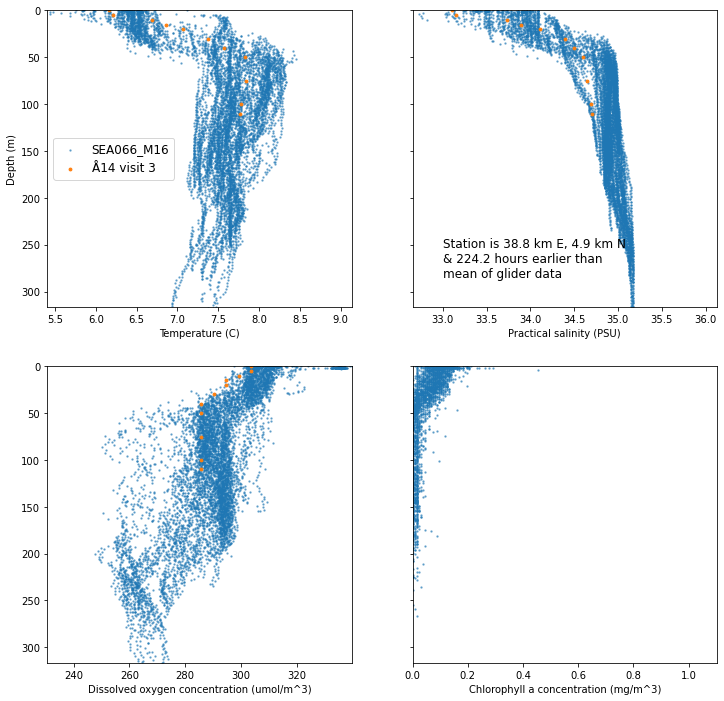

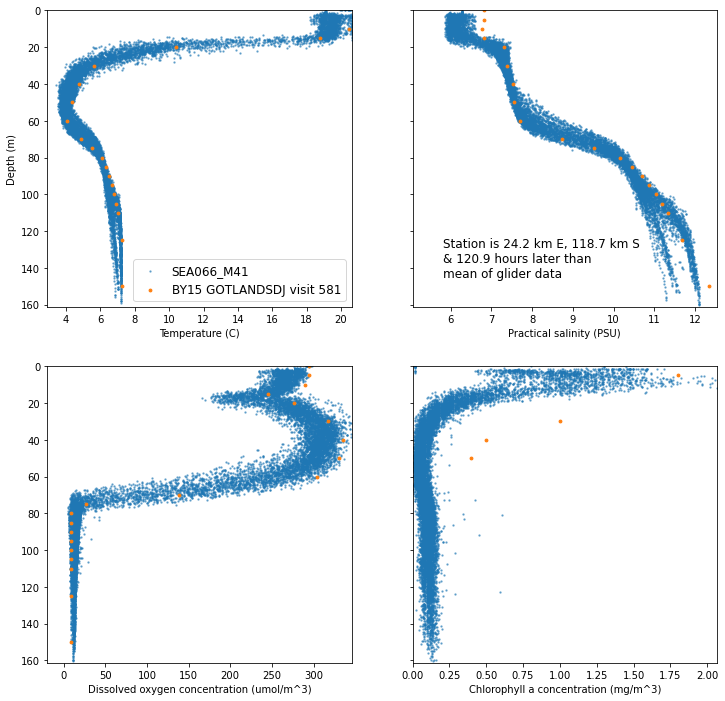

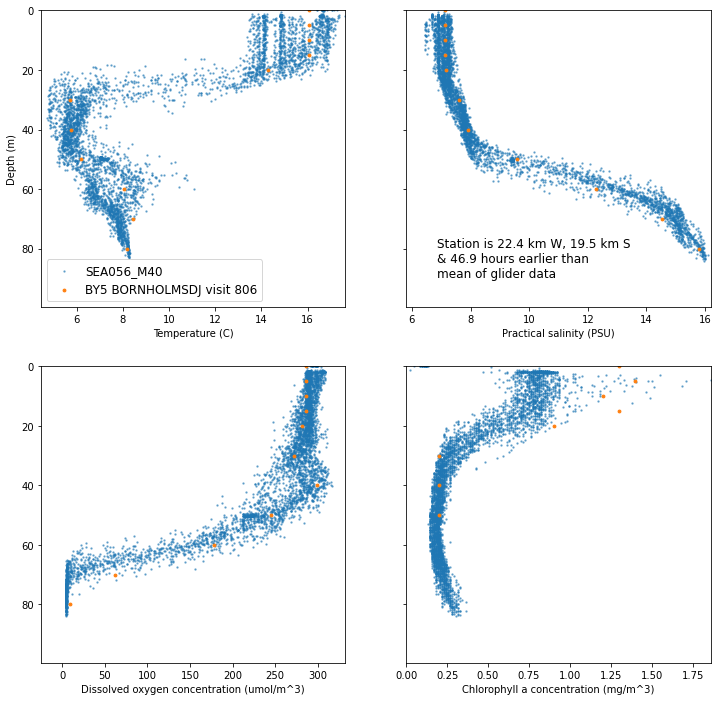

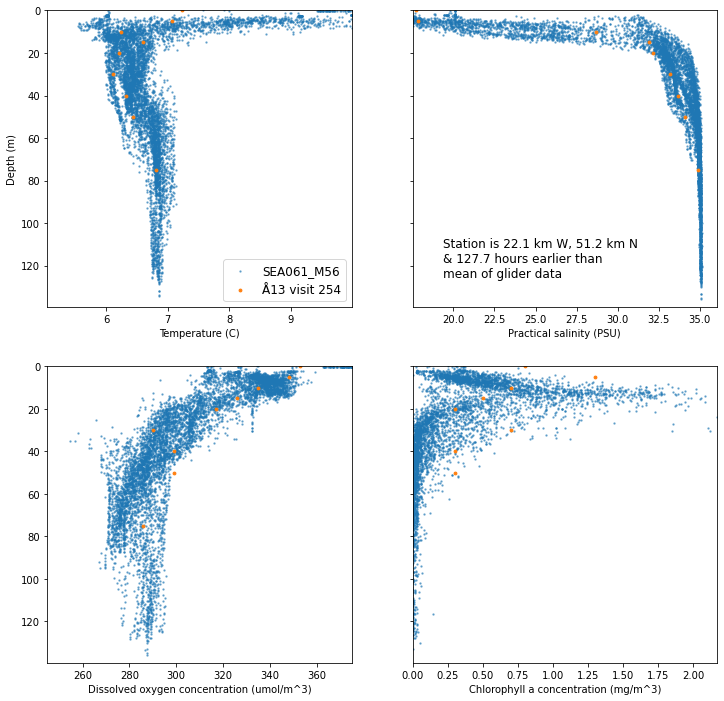

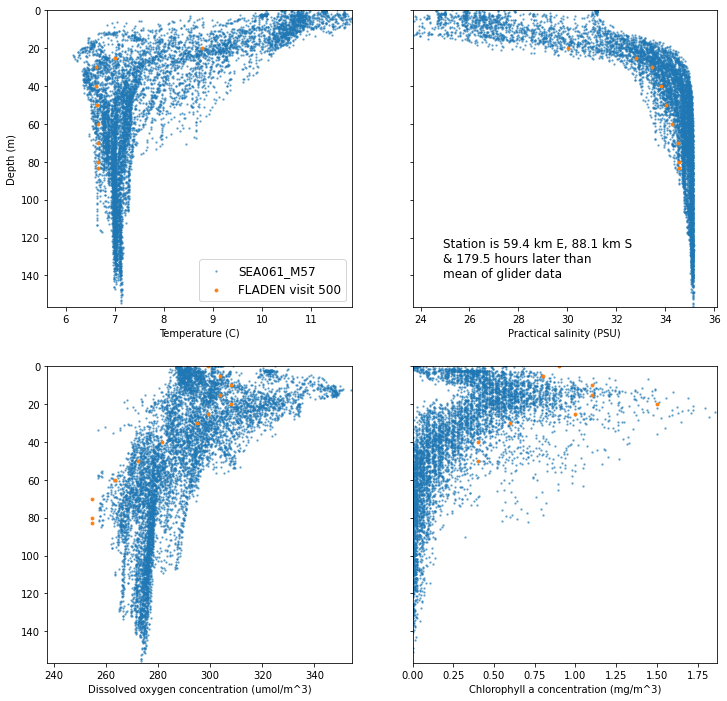

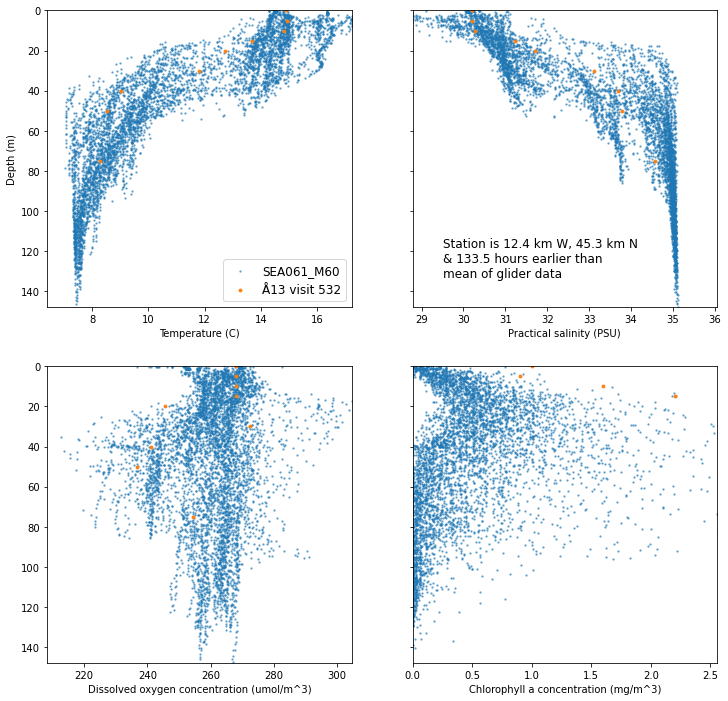

In [21]:
def compare_scatter(name, ds_glider, df_smhi):
    """
    Create scatter plots of temperature and salinity to visually compare glider and SMHI station data
    """
    fig, ax = plt.subplots(2,2, sharey="row", figsize=(12, 12))
    ax = ax.ravel()
    ylim = [0, np.nanpercentile(ds_glider.depth, 99)+20]
    
    
    smhi_name = f"{df_smhi['station_name'].values[0]} visit {df_smhi['visit_id'].values[0]}"
    df_temp = df_smhi[df_smhi['parameter']=="Temperature CTD"]
    temp_lim = [np.nanpercentile(ds_glider.temperature,5)-1, np.nanpercentile(ds_glider.temperature,95)+1]
    ax[0].scatter(ds_glider.temperature, ds_glider.depth, s=2, label=name[4:], alpha=0.5)
    ax[0].scatter(df_temp["value"].astype(float), df_temp['sample_depth_m'], s=8, label=smhi_name)
    ax[0].set(ylabel="Depth (m)", xlabel="Temperature (C)", xlim=temp_lim, ylim=ylim)
    ax[0].invert_yaxis()

    df_sal = df_smhi[df_smhi['parameter']=="Salinity CTD"]    
    sal_lim = [np.nanpercentile(ds_glider.salinity,5)-1, np.nanpercentile(ds_glider.salinity,95)+1]
    ax[1].scatter(ds_glider.salinity, ds_glider.pressure, s=2, alpha=0.5)
    ax[1].scatter(df_sal["value"].astype(float), df_sal['sample_depth_m'], s=8)
    ax[1].set(xlabel="Practical salinity (PSU)", xlim=sal_lim)
    ax[0].legend(fontsize=12)

    
    df_oxy = df_smhi[df_smhi['parameter']=="Dissolved oxygen O2 CTD"]   
    oxy_lim = [np.nanpercentile(ds_glider.oxygen_concentration,5)-30, np.nanpercentile(ds_glider.oxygen_concentration,95)+30]
    ax[2].scatter(ds_glider.oxygen_concentration, ds_glider.pressure, s=2, alpha=0.5)
    ax[2].scatter(df_oxy["value"].astype(float) * 44.66, df_oxy['sample_depth_m'], s=8)
    ax[2].set(xlabel="Dissolved oxygen concentration (umol/m^3)", xlim=oxy_lim, ylim=ylim)
    ax[2].invert_yaxis()

    
    df_chl = df_smhi[df_smhi['parameter']=="Chlorophyll-a bottle"]    
    chl_lim = [0, np.nanpercentile(ds_glider.chlorophyll,95)+1]
    ax[3].scatter(ds_glider.chlorophyll, ds_glider.pressure, s=2, alpha=0.5)
    ax[3].scatter(df_chl["value"].astype(float), df_chl['sample_depth_m'], s=8)
    ax[3].set(xlabel="Chlorophyll a concentration (mg/m^3)", xlim=chl_lim)
    
    deg_e = df_smhi['sample_longitude_dd'].values[0] - np.nanmean(ds_glider.longitude)
    deg_n = df_smhi['sample_latitude_dd'].values[0] - np.nanmean(ds_glider.latitude)
    time_diff = df_smhi['visit_date'].values[0] - ds_glider.time.mean()
    east_diff, north_diff, time_diff = format_difference(deg_e, deg_n, time_diff)
    loc_str = f"Station is {east_diff}, {north_diff}\n& {time_diff} than \nmean of glider data"
    ax[1].text(0.1, 0.1, loc_str, fontsize=12, transform=ax[1].transAxes)
    
    plt.savefig(f"figures/smhi_{name}.png")
    #plt.close("all")

for name, df_smhi in smhi_datasets.items():
    if df_smhi is not None:
        compare_scatter(name, glider_datasets[name], df_smhi)

# Comparative map

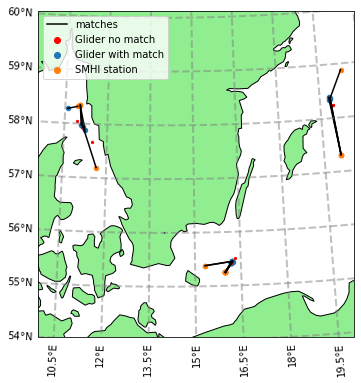

In [22]:
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=14, central_latitude=56)
pc = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=coord)
ax.set_extent([10, 20, 54, 60], crs=pc)

feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
                                              scale='50m', edgecolor='black', facecolor='lightgreen')
ax.add_feature(feature)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = None
gl.right_labels = None

for name, df_smhi in smhi_datasets.items():
    ds_glider = glider_datasets[name]
    if df_smhi is not None:
        lon = [df_smhi['sample_longitude_dd'].values[0], np.nanmean(ds_glider.longitude)]
        lat = [df_smhi['sample_latitude_dd'].values[0], np.nanmean(ds_glider.latitude)]
        ax.plot(lon, lat, transform=pc, color="k")
        ax.scatter(np.nanmean(ds_glider.longitude), np.nanmean(ds_glider.latitude), transform=pc, color="C0", s=20)
        ax.scatter(df_smhi['sample_longitude_dd'].values[0], df_smhi['sample_latitude_dd'].values[0],transform=pc, color="C1", s=20)
    else:
        ax.scatter(np.nanmean(ds_glider.longitude), np.nanmean(ds_glider.latitude),transform=pc, s=5, color="red")

ax.plot((0,1), (0,1),color="k", label="matches")
ax.scatter((0,1), (0,1),color="red", label="Glider no match")
ax.scatter((0,1), (0,1),color="C0", label="Glider with match")
ax.scatter((0,1), (0,1),color="C1", label="SMHI station")

ax.legend()
fig.savefig(f"figures/smhi_map.png")
